In [ ]:
# default_exp models.TSiTPlus

# TSiT & InceptionTSiT

> These are PyTorch implementations created by Ignacio Oguiza (timeseriesAI@gmail.com) based on ViT (Vision Transformer)
     
Reference: 

     Dosovitskiy, A., Beyer, L., Kolesnikov, A., Weissenborn, D., Zhai, X., Unterthiner, T., ... & Houlsby, N. (2020).
     An image is worth 16x16 words: Transformers for image recognition at scale. arXiv preprint arXiv:2010.11929.

     This implementation is a modified version of Vision Transformer that is part of the grat timm library
     (https://github.com/rwightman/pytorch-image-models/blob/72b227dcf57c0c62291673b96bdc06576bb90457/timm/models/vision_transformer.py)

In [ ]:
#export
from tsai.imports import *
from tsai.utils import *
from tsai.models.layers import *
from tsai.models.InceptionTimePlus import InceptionBlockPlus
from typing import Callable

In [ ]:
# export

class _TSiTEncoder(nn.Module):
    def __init__(self, d_model, n_heads, n_layers:int=6, attn_drop_rate:float=0, mlp_drop_rate:float=0, drop_path_rate:float=0., 
                 mlp_ratio:int=1, qkv_bias:bool=True, act:str='reglu', pre_norm:bool=False):
        super().__init__()
        
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, n_layers)]
        self.layers = nn.ModuleList([])
        for i in range(n_layers):
            self.layers.append(nn.ModuleList([
                MultiheadAttention(d_model, n_heads, dropout=attn_drop_rate, qkv_bias=qkv_bias), nn.LayerNorm(d_model),
                PositionwiseFeedForward(d_model, dropout=mlp_drop_rate, act=act, mlp_ratio=mlp_ratio), nn.LayerNorm(d_model),
                # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
                DropPath(dpr[i]) if dpr[i] != 0 else nn.Identity(),
                # nn.Dropout(drop_path_rate) if drop_path_rate != 0 else nn.Identity()
            ]))
        self.pre_norm = pre_norm
        self.norm = nn.LayerNorm(d_model) if self.pre_norm else nn.Identity()

    def forward(self, x):
        for i, (mha, attn_norm, pwff, ff_norm, drop_path) in enumerate(self.layers):
            if self.pre_norm:
                x = drop_path(mha(attn_norm(x))[0]) + x
                x = drop_path(pwff(ff_norm(x))) + x
            else:
                x = attn_norm(drop_path(mha(x)[0]) + x)
                x = ff_norm(drop_path(pwff(x)) + x)
        
        x = self.norm(x)
        return x


class _TSiTBackbone(Module):
    def __init__(self, c_in:int, seq_len:int, n_layers:int=6, d_model:int=128, n_heads:int=16, d_head:Optional[int]=None, act:str='reglu',
                 d_ff:int=256, qkv_bias:bool=True, pos_dropout:float=0., attn_drop_rate:float=0, mlp_drop_rate:float=0, drop_path_rate:float=0., 
                 mlp_ratio:int=1, pre_norm:bool=False, use_token:bool=True, ks:Optional[int]=None, maxpool:bool=True, 
                 preprocessor:Optional[Callable]=None, device=None, verbose:bool=False):

        device = ifnone(device, default_device())
        self.preprocessor = nn.Identity()
        if preprocessor is not None:
            xb = torch.randn(1, c_in, seq_len).to(device)
            ori_c_in, ori_seq_len = c_in, seq_len
            if not isinstance(preprocessor, nn.Module): preprocessor = preprocessor(c_in, d_model).to(device)
            else: preprocessor = preprocessor.to(device)
            with torch.no_grad():
                # NOTE Most reliable way of determining output dims is to run forward pass
                training = preprocessor.training
                if training:
                    preprocessor.eval()
                c_in, seq_len = preprocessor(xb).shape[1:]
                preprocessor.train(training)
            pv(f'preprocessor: (?, {ori_c_in}, {ori_seq_len}) --> (?, {c_in}, {seq_len})', verbose=verbose)
            self.preprocessor = preprocessor
        
        if seq_len == d_model: 
            self.to_embedding = Transpose(1,2)
        elif ks is not None: 
            self.to_embedding = nn.Sequential(MultiConcatConv1d(c_in, d_model, kss=ks, maxpool=maxpool),Transpose(1,2))
        else: 
            self.to_embedding = nn.Sequential(Conv1d(c_in, d_model, 1),Transpose(1,2))
        self.pos_embedding = nn.Parameter(torch.zeros(1, seq_len, d_model))
        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_model))
        self.use_token = use_token
        self.pos_dropout = nn.Dropout(pos_dropout)

        self.encoder = _TSiTEncoder(d_model, n_heads, n_layers=n_layers, qkv_bias=qkv_bias, attn_drop_rate=attn_drop_rate, mlp_drop_rate=mlp_drop_rate,
                                    mlp_ratio=mlp_ratio, drop_path_rate=drop_path_rate, act=act, pre_norm=pre_norm)

    def forward(self, x):

        # apply preprocessor module if exists
        x = self.preprocessor(x)
        
        # embedding
        x = self.to_embedding(x)
        x = x + self.pos_embedding
        if self.use_token:
            x = torch.cat((self.cls_token.expand(x.shape[0], -1, -1), x), dim=1)
        x = self.pos_dropout(x)

        x = self.encoder(x)

        x = x.transpose(1,2)
        return x


class TSiTPlus(nn.Sequential):
    """Time series transformer model based on ViT (Vision Transformer):

    Dosovitskiy, A., Beyer, L., Kolesnikov, A., Weissenborn, D., Zhai, X., Unterthiner, T., ... & Houlsby, N. (2020).
    An image is worth 16x16 words: Transformers for image recognition at scale. arXiv preprint arXiv:2010.11929.

    This implementation is a modified version of Vision Transformer that is part of the grat timm library
    (https://github.com/rwightman/pytorch-image-models/blob/72b227dcf57c0c62291673b96bdc06576bb90457/timm/models/vision_transformer.py)

    Args:
    =====

    c_in:                   the number of features (aka variables, dimensions, channels) in the time series dataset.
    c_out:                  the number of target classes.
    seq_len:                number of time steps in the time series.
    n_layers:               number of layers (or blocks) in the encoder. Default: 3 (range(1-4))
    d_model:                total dimension of the model (number of features created by the model). Default: 128 (range(64-512))
    n_heads:                parallel attention heads. Default:16 (range(8-16)).
    d_head:                 size of the learned linear projection of queries, keys and values in the MHA. Usual values: 16-512. 
                            Default: None -> (d_model/n_heads) = 32.
    act:                    the activation function of intermediate layer, relu, gelu, geglu, reglu.
    d_ff:                   the dimension of the feedforward network model. Default: 512 (range(256-512))
    pos_dropout:            dropout applied to to the embedded sequence steps after position embeddings have been added.
    attn_drop_rate (float): dropout rate applied to the attention layer
    mlp_drop_rate (float):  dropout rate applied to the mlp layer
    drop_path_rate:         dropout applied to the output of MultheadAttention and PositionwiseFeedForward layers.
    mlp_ratio:              ratio of mlp hidden dim to embedding dim.
    qkv_bias:               determines whether bias is applied to the Linear projections of queries, keys and values in the MultiheadAttention
    pre_norm:               if True normalization will be applied as the first step in the sublayers. Defaults to False.
    use_token:              if True, the output will come from the transformed token. Otherwise a pooling layer will be applied.
    fc_dropout:             dropout applied to the final fully connected layer.
    bn:                     indicates if batchnorm will be applied to the head.
    y_range:                range of possible y values (used in regression tasks).
    ks:                     (Optional) kernel sizes that will be applied to a hybrid embedding.
    maxpool:                If true and kernel sizes are passed, maxpool will also be added to the hybrid embedding.
    preprocessor:           an optional callable (nn.Conv1d with dilation > 1 or stride > 1 for example) that will be used to preprocess the time series before 
                            the embedding step. It is useful to extract features or resample the time series.
    custom_head:            custom head that will be applied to the network. It must contain all kwargs (pass a partial function)

    Input shape:
        x: bs (batch size) x nvars (aka features, variables, dimensions, channels) x seq_len (aka time steps)
    """


    def __init__(self, c_in:int, c_out:int, seq_len:int, n_layers:int=6, d_model:int=128, n_heads:int=16, d_head:Optional[int]=None, act:str='reglu',
                 d_ff:int=256, pos_dropout:float=0., attn_drop_rate:float=0, mlp_drop_rate:float=0, drop_path_rate:float=0., mlp_ratio:int=1,
                 qkv_bias:bool=True, pre_norm:bool=False, use_token:bool=True, fc_dropout:float=0., bn:bool=True, y_range:Optional[tuple]=None, 
                 ks:Optional[int]=None, maxpool:bool=True, preprocessor:Optional[Callable]=None, custom_head:Optional[Callable]=None, verbose:bool=False):

        backbone = _TSiTBackbone(c_in, seq_len, n_layers=n_layers, d_model=d_model, n_heads=n_heads, d_head=d_head, act=act,
                                          d_ff=d_ff, pos_dropout=pos_dropout, attn_drop_rate=attn_drop_rate, mlp_drop_rate=mlp_drop_rate, 
                                          drop_path_rate=drop_path_rate, pre_norm=pre_norm, mlp_ratio=mlp_ratio, use_token=use_token, 
                                          ks=ks, maxpool=maxpool, preprocessor=preprocessor, verbose=verbose)

        self.head_nf = d_model
        self.c_out = c_out
        self.seq_len = seq_len
        if custom_head: 
            head = custom_head(self.head_nf, c_out, self.seq_len) # custom head passed as a partial func with all its kwargs
        else:
            layers = [TokenLayer(token=use_token)]
            layers += [LinBnDrop(d_model, c_out, bn=bn, p=fc_dropout)]
            if y_range: layers += [SigmoidRange(*y_range)]
            head = nn.Sequential(*layers)
        super().__init__(OrderedDict([('backbone', backbone), ('head', head)]))

        
TSiT = named_partial('TSiT', TSiTPlus)
InceptionTSiTPlus = named_partial("InceptionTSiTPlus", TSiTPlus, preprocessor=partial(InceptionBlockPlus, ks=[3,5,7]))
InceptionTSiT = named_partial("InceptionTSiT", TSiTPlus, preprocessor=partial(InceptionBlockPlus, ks=[3,5,7]))

In [ ]:
bs = 16
nvars = 4
seq_len = 50
c_out = 2
xb = torch.rand(bs, nvars, seq_len)
model = TSiTPlus(nvars, c_out, seq_len)
test_eq(model(xb).shape, (bs, c_out))
model

TSiTPlus(
  (backbone): _TSiTBackbone(
    (preprocessor): Identity()
    (to_embedding): Sequential(
      (0): Conv1d(4, 128, kernel_size=(1,), stride=(1,))
      (1): Transpose(1, 2)
    )
    (pos_dropout): Dropout(p=0.0, inplace=False)
    (encoder): _TSiTEncoder(
      (layers): ModuleList(
        (0): ModuleList(
          (0): MultiheadAttention(
            (W_Q): Linear(in_features=128, out_features=128, bias=True)
            (W_K): Linear(in_features=128, out_features=128, bias=True)
            (W_V): Linear(in_features=128, out_features=128, bias=True)
            (sdp_attn): ScaledDotProductAttention()
            (to_out): Sequential(
              (0): Linear(in_features=128, out_features=128, bias=True)
              (1): Dropout(p=0, inplace=False)
            )
          )
          (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (2): PositionwiseFeedForward(
            (0): Linear(in_features=128, out_features=256, bias=True)
            (1):

In [ ]:
bs = 16
nvars = 4
seq_len = 50
c_out = 2
xb = torch.rand(bs, nvars, seq_len)
model = InceptionTSiTPlus(nvars, c_out, seq_len)
test_eq(model(xb).shape, (bs, c_out))

/Users/nacho/anaconda3/envs/py36/lib/python3.6/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


### Subsampling

It's a known fact that transformers cannot be directly applied to long sequences. To avoid this, we have included a way to subsample the sequence to generate a more manageable input.

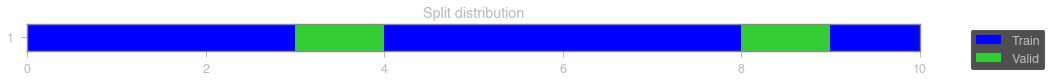

TSTensor(samples:8, vars:3, len:5000, device=cpu)

In [ ]:
from tsai.data.validation import get_splits
from tsai.data.core import get_ts_dls
X = np.zeros((10, 3, 5000)) 
y = np.random.randint(0,2,X.shape[0])
splits = get_splits(y)
dls = get_ts_dls(X, y, splits=splits)
xb, yb = dls.train.one_batch()
xb

If you try to use TSiTPlus, it's likely you'll get an 'out-of-memory' error.

To avoid this you can subsample the sequence reducing the input's length. This can be done in multiple ways. Here are a few examples: 

In [ ]:
# Separable convolution (to avoid mixing channels)
preprocessor = Conv1d(xb.shape[1], xb.shape[1], ks=100, stride=50, padding='same', groups=xb.shape[1]).to(default_device())
preprocessor(xb).shape

torch.Size([8, 3, 100])

In [ ]:
# Convolution (if you want to mix channels or change number of channels)
preprocessor = Conv1d(xb.shape[1], 2, ks=100, stride=50, padding='same').to(default_device())
preprocessor(xb).shape

torch.Size([8, 2, 100])

In [ ]:
# MaxPool
preprocessor = nn.Sequential(Pad1d((0, 50), 0), nn.MaxPool1d(kernel_size=100, stride=50)).to(default_device())
preprocessor(xb).shape

torch.Size([8, 3, 100])

In [ ]:
# AvgPool
preprocessor = nn.Sequential(Pad1d((0, 50), 0), nn.AvgPool1d(kernel_size=100, stride=50)).to(default_device())
preprocessor(xb).shape

torch.Size([8, 3, 100])

Once you decide what type of transform you want to apply, you just need to pass the layer as the preprocessor attribute:

In [ ]:
bs = 16
nvars = 4
seq_len = 1000
c_out = 2
d_model = 128

xb = torch.rand(bs, nvars, seq_len)
preprocessor = partial(Conv1d, ks=5, stride=3, padding='same', groups=xb.shape[1])
model = TSiTPlus(nvars, c_out, seq_len, d_model=d_model, preprocessor=preprocessor)
test_eq(model(xb).shape, (bs, c_out))

In [ ]:
#hide
out = create_scripts()
beep(out)

<IPython.core.display.Javascript object>

Converted 000_utils.ipynb.
Converted 000b_data.validation.ipynb.
Converted 000c_data.preparation.ipynb.
Converted 001_data.external.ipynb.
Converted 002_data.core.ipynb.
Converted 002b_data.unwindowed.ipynb.
Converted 002c_data.metadatasets.ipynb.
Converted 003_data.preprocessing.ipynb.
Converted 003b_data.transforms.ipynb.
Converted 003c_data.mixed_augmentation.ipynb.
Converted 003d_data.image.ipynb.
Converted 003e_data.features.ipynb.
Converted 005_data.tabular.ipynb.
Converted 006_data.mixed.ipynb.
Converted 050_losses.ipynb.
Converted 051_metrics.ipynb.
Converted 052_learner.ipynb.
Converted 052b_tslearner.ipynb.
Converted 053_optimizer.ipynb.
Converted 060_callback.core.ipynb.
Converted 061_callback.noisy_student.ipynb.
Converted 063_callback.MVP.ipynb.
Converted 064_callback.PredictionDynamics.ipynb.
Converted 100_models.layers.ipynb.
Converted 100b_models.utils.ipynb.
Converted 100c_models.explainability.ipynb.
Converted 101_models.ResNet.ipynb.
Converted 101b_models.ResNetPlus.